# Transfer Learning

__Original notebook is available here:__ https://www.kaggle.com/code/dansbecker/transfer-learning

If you took the [Computer Vision course](https://www.kaggle.com/learn/computer-vision), you learned how to use a model to make predictions. But what if you have a new use-case, and you don’t categorize images in exactly the same way as the categories for your original model?

For example, I might want a model that can tell if a photo was taken in an urban area or a rural area, but my original model doesn’t classify images into those two specific categories.  I could build a new model from scratch for this specific purpose. But to get good results, I’d need thousands of photos with labels for which are urban and which are rural.

A method called transfer learning will give good results with far less data. Transfer learning takes what a model learned while solving one problem (called a **pre-trained model**, because the model has already been trained on a different dataset), and applies it to a new application.

# Goal of this Notebook

[ImageNet](https://en.wikipedia.org/wiki/ImageNet) is a very large image dataset, composed of over 14 million images from thousands of categories.  Keras makes available several models that have been pre-trained on this dataset [here](https://keras.io/api/applications/).  One of the models is [ResNet](https://keras.io/api/applications/resnet/#resnet50-function).

In this notebook, we'll show you how to adapt the pre-trained ResNet model to a new task to predict if an image is rural or urban.  You'll work with [this dataset](https://www.kaggle.com/datasets/dansbecker/urban-and-rural-photos).

# Background

Remember that early layers of a deep learning model identify simple shapes. Later layers identify more complex visual patterns, like roads, buildings, windows, and open fields. These layers will be useful in our new application.  

<img src="https://i.imgur.com/NdcEZhf.png" width=500px>

The very last layer makes predictions.  We’ll drop in a replacement for this last layer of the ResNet model. 

The replacement is a dense layer with two nodes. One node captures how urban the photo is, and the other captures how rural it is. In theory, any node in the last layer before prediction might inform how urban it is. So the urban measure can depend on all the nodes in this layer.  We draw connections to show that possible relationship.  For the same reason, the information at each node might affect our measure of how rural the photo is.

<img src="https://i.imgur.com/ZsJWiDV.png" width=350px>


We have a lot of connections here, and we’ll use training data to determine which nodes suggest an image is urban, which suggest it is rural, and which don’t matter.  That is, we’re going to be training the last layer of the model. In practice, that training data will be photos that are labeled as either rural or urban.  

Note: When classifying something into only 2 categories, we could get by with only one node at the output.  In this case, a prediction for how urban a photo is would also be a measure of how rural it is.  If a photo is 80% likely to be urban, it would be 20% likely to be rural. But we’ve kept two separate nodes at the output layer.  Using a separate node for each possible category in the output layer will help us transition to cases when we want to predict with more than 2 categories.

# Code

### Specify the Model

In this application, we classify photos into 2 categories or classes, urban and rural. We’ll save that as `num_classes`.

Next we build the model. We set up a sequential model that we can add layers to. First we add a pre-trained ResNet model. When creating the ResNet model, we’ve written `include_top=False`. This is how we specify that we want to exclude the last layer of the ResNet model that makes predictions.  We’ll also use a file that doesn’t include the weights for that layer.

The argument `pooling='avg'` says that if we had extra channels in our tensor at the end of this step, we want to collapse them to a 1D tensor by taking an average.  Now we have a pretrained model that creates the layer you saw in the graphic.  We’ll add a `Dense` layer to make predictions.  We specify the number of nodes in this layer, which in this case is the number of classes. Then we apply the softmax function to produce probabilities.

<img src="https://i.imgur.com/RutdkVs.png" width=500px>

Finally, we’ll tell TensorFlow not to train the first layer of the sequential model, the ResNet50 layers. This is because that’s the model that was already pre-trained with the ImageNet data. 


In [1]:
# set random seed / make reproducible
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer

num_classes = 2
batch_size = 32

my_new_model = Sequential()
my_new_model.add(InputLayer(input_shape=(224,224,3), batch_size=batch_size))
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
my_new_model.add(Dense(num_classes, activation='softmax'))

my_new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (32, 2)                   4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 23538690 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [3]:
# checking the layers in the my_new_model
my_new_model.layers

In [4]:
# checking the layers in the ResNet model
my_new_model.layers[0].layers

In [5]:
# checking if the layers are trainable
for layer in my_new_model.layers:
    print(f'Layer name: {layer}, is trainable: {layer.trainable}')

Layer name: <keras.src.engine.functional.Functional object at 0x0000028D3E255150>, is trainable: True
Layer name: <keras.src.layers.core.dense.Dense object at 0x0000028D3CD2EE10>, is trainable: True


In [6]:
# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

In [7]:
# checking if the layers are trainable
for layer in my_new_model.layers:
    print(f'Layer name: {layer}, is trainable: {layer.trainable}') 

Layer name: <keras.src.engine.functional.Functional object at 0x0000028D3E255150>, is trainable: False
Layer name: <keras.src.layers.core.dense.Dense object at 0x0000028D3CD2EE10>, is trainable: True


### Compile the Model

The compile command tells TensorFlow how to update the relationships in the final layer of the network during training.

We have a measure of loss or inaccuracy we want to minimize. We specify it as `categorical_crossentropy`. If you are familiar with log-loss, this is another term for the same thing.

We use an algorithm called stochastic gradient descent (SGD) to minimize the categorical cross-entropy loss. 

We ask the code to report the accuracy metric, the fraction of correct predictions. This is easier to interpret than categorical cross-entropy scores, so it’s nice to print it out and see how the model is doing.

In [8]:
my_new_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Load the Image Data

Our raw data is broken into a directory of training data and a directory of validation data. Within each of those, we have one subdirectory for the urban pictures and another for the rural pictures. TensorFlow provides a great tool for working with images grouped into directories by their label.  This is the `ImageDataGenerator`. 

There are two steps to using `ImageDataGenerator`. First we create the generator object in the abstract. We want to apply the ResNet preprocessing function every time it reads in an image. 

Then we use the `flow_from_directory` command. We tell it what directory that data is in, what size image we want, how many images to read in at a time (the batch size), and we tell it we’re classifying data into different categories. We do the same thing to set up a way to read the validation data.

`ImageDataGenerator` is especially very valuable when working with large datasets, because we don’t need to hold the whole dataset in memory at once. But it’s also nice here, with a small dataset. Note that these are generators which means we need to iterate over them to get data out.

In [9]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = data_generator.flow_from_directory(
        os.path.join('images', 'train'),
        target_size=(image_size, image_size),
        batch_size=12,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        os.path.join('images', 'val'),
        target_size=(image_size, image_size),
        batch_size=20,
        class_mode='categorical')

Found 72 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


### Fit the Model

Now we fit the model.  The training data comes from `train_generator`, and the validation data comes from `validation_generator`.  Since we have 72 training images and read in 12 images at a time, we use 6 steps for a single epoch (`steps_per_epoch=6`).  Likewise, we have 20 validation images, and use one validation step since we read in all 20 images in a single step (`validation_steps=1`).

As the model training is running, we’ll see progress updates showing with our loss function and the accuracy. It updates the connections in the dense layer, that is the model’s impression of what makes an urban photo and what makes a rural photo. When it’s done, it gets 78% of the training data right.  Then it examines the validation data. It gets 90% of those right. 

I should mention that this is a really small dataset and you should be hesitant about relying on validation scores from such a small amount of data.  We’re starting with small datasets so you can get some experience under your belt with models that can be trained quickly.

In [10]:
my_new_model.fit(
        train_generator,
        steps_per_epoch=6,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=1
        )

Epoch 1/5
6/6 [==============================] - 8s 854ms/step - loss: 1.0231 - accuracy: 0.7083 - val_loss: 0.1376 - val_accuracy: 1.0000
Epoch 2/5
6/6 [==============================] - 4s 624ms/step - loss: 0.0676 - accuracy: 1.0000 - val_loss: 0.1049 - val_accuracy: 0.9500
Epoch 3/5
6/6 [==============================] - 4s 619ms/step - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0.0923 - val_accuracy: 1.0000
Epoch 4/5
6/6 [==============================] - 4s 614ms/step - loss: 0.0304 - accuracy: 1.0000 - val_loss: 0.0854 - val_accuracy: 1.0000
Epoch 5/5
6/6 [==============================] - 4s 614ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 1.0000


Even with the small training dataset, this accuracy score is really good. We trained on 72 photos. You could easily take that many photos on your phone, upload them to [Kaggle Datasets](https://www.kaggle.com/datasets), and build a very accurate model to distinguish almost anything you care about. 

### Note on Results
The printed validation accuracy can be meaningfully better than the training accuracy at this stage. This can be puzzling at first.

It occurs because the training accuracy was calculated at multiple points as the network was improving (the numbers in the convolutions were being updated to make the model more accurate).  The network was inaccurate when the model saw the first training images, since the weights hadn't been trained/improved much yet.  Those first training results were averaged into the measure above.

The validation loss and accuracy measures were calculated **after** the model had gone through all the data.  So the network had been fully trained when these scores were calculated.

This isn't a serious issue in practice, and we tend not to worry about it.

In [11]:
my_new_model.history

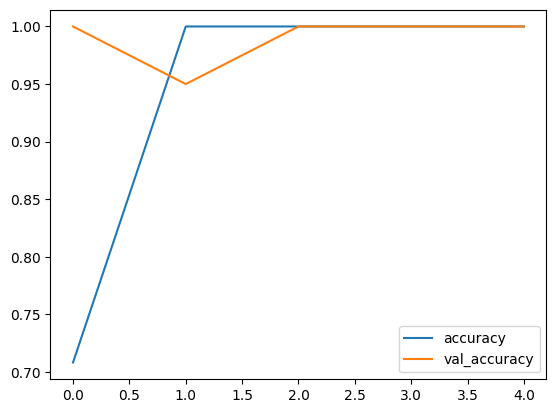

In [12]:
plt.plot(my_new_model.history.epoch, my_new_model.history.history['accuracy'])
plt.plot(my_new_model.history.epoch, my_new_model.history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

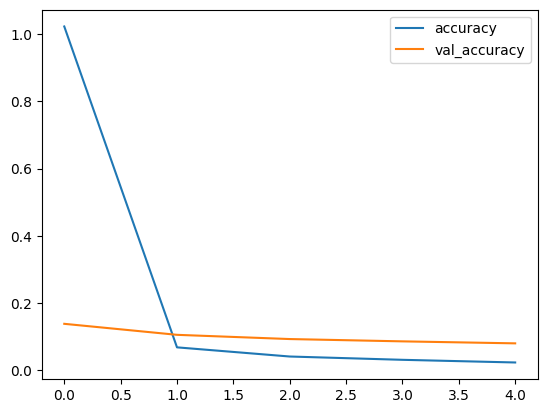

In [13]:
plt.plot(my_new_model.history.epoch, my_new_model.history.history['loss'])
plt.plot(my_new_model.history.epoch, my_new_model.history.history['val_loss'])
plt.legend(['accuracy','val_accuracy'])
plt.show()